In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from nltk.corpus import stopwords
import collections
import datetime as dt
import os
import itertools
import warnings
import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from tensorflow.keras.layers import Input, concatenate, Activation, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import keras_metrics as km

pd.options.display.max_colwidth = 200

import nltk
nltk.download('stopwords')

/home/ubuntu/.local/share/virtualenvs/sentiment-analysis-u1HjeCHg/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
2021-08-09 18:44:06.915815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-09 18:44:06.915846: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
def make_xy(df_train, df_test, vectorizer=None):
    ''' 
    This function makes training and testing data from Term Frequency-Inverse Document Frequency (TFIDF)
    vectors based on how often words appears in any given document and accross all documents.
    '''
    if vectorizer is None:
        # make vectorizer to transform text documents to TFIDF vectors
        vectorizer = TfidfVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b')
    
    # fit vectorizer to training Tweets and transform training and testing Tweets to vectors
    x_train = vectorizer.fit_transform(df_train.tweet.values.astype(str))
    y_train = (df_train.sentiment == 'negative').values.astype(np.int)
    x_test = vectorizer.transform(df_test.tweet.values.astype(str))
    y_test = (df_test.sentiment == 'negative').values.astype(np.int)
    
    return x_train, y_train, x_test, y_test


def return_time(seconds):
    '''
    This function returns 'seconds' in "h hours, m minutes, s seconds" format.
    '''
    # create timedelta object (in HH:MM:SS format) from seconds and convert to string
    d = str(dt.timedelta(seconds=round(seconds)))
    
    # slice timedelta string to select corresponding hours, minutes, and seconds
    hours = d[:len(d)-6]
    minutes = d[-5:-3]
    seconds_left = d[-2:]
    
    # set and join time variables and corresponding time unit strings
    periods = [('hours', hours), ('minutes', minutes), ('seconds', seconds_left)]
    time_string = ' '.join('{} {}'.format(value, name)
                        for name, value in periods
                        if int(value) != 0)
    
    return time_string


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix (cm) and normalized confusion matrix (in parentheses)
    as calculated from sklearn.metrics.confusion_matrix().
    """
    # normalize confusion matix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # create figure
    plt.figure(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # plot confusion matrix values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    # plot normalized confusion matrix values
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i+.07, '(' + format(cm_norm[i, j], '.2f') + ')',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def get_best_model(min_dfs, model_cv):
    '''
    This function finds the best min_df and max_df parameters used in TfidfVectorizer for GridSearchCV models,
    fits model with best parameters on training data, and prints the sklearn.metrics.classification_report and 
    plots the confusion matrix of model results on test data.
    '''
    print('Finding best min_df...')
    prev_score = 0
    
    def get_best_max_df(min_df, model_cv):
        '''
        This helper function finds the best max_df parameter and then fits model with best parameters on 
        training data, and prints the sklearn.metrics.classification_report and plots the confusion matrix 
        of model results on test data.
        '''
        print('Finding best max_df...')
        prev_score = 0
        
        for max_df in np.arange(.1, 1.1, .1)[::-1]: # range of values to look for best max_df: [1, .9, .8, ... .1]
            start = time.time()
            
            # make training and testing data for each max_df in range of values
            x_train, y_train, x_test, y_test = make_xy(df_tweets_train, 
                                                       df_tweets_test,
                                                       vectorizer=TfidfVectorizer(ngram_range=(1,2), 
                                                                                  token_pattern=r'\b\w+\b',
                                                                                  min_df=min_df,
                                                                                  max_df=max_df))
            
            # fit model and compare to previous model to see if it's scoring metric is higher or lower
            model_cv.fit(x_train, y_train)
            curr_score = np.mean(model_cv.cv_results_['mean_test_score'])
            
            # print results and continue if current scoring metric is higher than previous
            if round(curr_score, 3) > round(prev_score, 3):
                print('max_df: {}, Mean CV {}: {:.3f}'.format(max_df, model_cv.scoring, curr_score))
                
            # if scoring metric lower than previous, stop, refit previous model and print results
            else:
                print('Best max_df: {}, Best mean CV {} {:.3f}'.format(max_df + 0.1, model_cv.scoring, prev_score))
                print()
                print('Fitting best model...')
                print()
                start = time.time()
                x_train, y_train, x_test, y_test = make_xy(df_tweets_train, 
                                                           df_tweets_test,
                                                           vectorizer=TfidfVectorizer(ngram_range=(1,2), 
                                                                                      token_pattern=r'\b\w+\b',
                                                                                      min_df=min_df,
                                                                                      max_df=max_df + 0.1))
                # fit best model, predict on test data, and print results
                best_cv_model = model_cv.fit(x_train, y_train)
                Y_pred = best_cv_model.predict(x_test)
                y_pred = np.rint(Y_pred).flatten()
                
                print()
                print(str(model_cv.estimator).split('(')[0] + ' Classification Report (Test Data)')
                print('--------------------------------------------------------')
                target_names = ['Positive', 'Negative']
                print(classification_report(y_test, y_pred, target_names=target_names))

                cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
                plot_confusion_matrix(cnf_matrix, classes=target_names,
                                      title=str(model_cv.estimator).split('(')[0] 
                                            + ' Confusion Matrix \n (Test Data)')
                return
            
            prev_score = curr_score
        
    # find best min_df parameter in the same way as get_best_max_df above 
    for min_df in min_dfs:
        start = time.time()
        x_train, y_train, x_test, y_test = make_xy(df_tweets_train, 
                                                   df_tweets_test,
                                                   vectorizer=TfidfVectorizer(ngram_range=(1,2), 
                                                                              token_pattern=r'\b\w+\b',
                                                                              min_df=min_df))
        model_cv.fit(x_train, y_train)
        curr_score = np.mean(model_cv.cv_results_['mean_test_score'])
            
        if round(curr_score, 3) > round(prev_score, 3):
            print('min_df: {}, Mean CV {}: {:.3f}'.format(min_df, 
                                                          model_cv.scoring, 
                                                          curr_score))
        else:
            print('Best min_df: {}, Best mean CV {}: {:.3f}'.format(min_df - 1, 
                                                                    model_cv.scoring, 
                                                                    prev_score))
            print()
            return get_best_max_df(min_df-1, model_cv)
        prev_score = curr_score
        
        
def count_tokens(tweet):
    '''
    This function counts the number of tokens (words for which an Word2Vec vector exists) in a Tweet.
    '''
    count = 0
    for word in tweet:
        if word in x_vectors:
            count += 1
    return count

In [3]:
df_labeled_tweets = pd.read_csv('../data/processed/labeled_tweets.csv')
df_tweets_train, df_tweets_test = train_test_split(df_labeled_tweets, test_size=0.2, random_state=7)

In [4]:
df_labeled_tweets['sentiment'].value_counts()

negative    114273
positive     45088
Name: sentiment, dtype: int64

In [5]:
df_tweets_train.head()

,tweet,sentiment,number of words
22149,buenaaas recien me levantar,positive,4
140730,tener 4 hora tratar de hacer tarea y no haber hacer ni madre,negative,13
66473,durar uno noche amándonos amp el otro pelear gt,negative,9
30788,sonja,positive,1
37622,obviamente tambien haber ganar como no ir ya ser para el otro,positive,12


In [6]:
nltk_stopwords = set(stopwords.words('spanish'))
print('Length of nltk stopwords: {}'.format(len(nltk_stopwords)))

Length of nltk stopwords: 313


### Multinomial Naive Bayes

First we'll see how Multinomial Naive Bayes performs with and without removing stopwords, then we'll tune and cross validate the better performing model (based on f1-score) using GridsearchCV and then we'll evaluate it on the test data.

In [7]:
# make testing and traning data with nltk stopwords removed
x_train, y_train, x_test, y_test = make_xy(df_tweets_train, 
                                           df_tweets_test, 
                                           vectorizer=TfidfVectorizer(ngram_range=(1, 2), 
                                                                      token_pattern=r'\b\w+\b',
                                                                      stop_words=nltk_stopwords))




# create parameter grid of alphas to search through
alphas = [.00001, .0001, .001, .01, .1, .5, .75, 1, 1.25, 5, 10, 50]
mnb_param_grid = {'alpha': alphas}

# build multinomial Naive Bayes model and cross validate using GridSearchCV
mnb = MultinomialNB(fit_prior=False)
mnb_cv = GridSearchCV(mnb, mnb_param_grid, scoring='f1', cv=10, n_jobs=-1)

start = time.time()
print()
print("Cross validating model (with stopwords removed)...")
print()
mnb_cv.fit(x_train, y_train)

print("10 fold CV results")
print("------------------")
print("Multinomial Naive Bayes took {} to fit.".format(return_time(time.time() - start)))
print("Mean CV f1-score: {:.3f}".format(np.mean(mnb_cv.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(mnb_cv.cv_results_['std_test_score'])))


# repeat without removing stopwords
x_train, y_train, x_test, y_test = make_xy(df_tweets_train, df_tweets_test)

start = time.time()
print()
print("Cross validating model (without removing stopwords)...")
print()
mnb_cv.fit(x_train, y_train)

print("10 fold CV results")
print("------------------")
print("Multinomial Naive Bayes took {} to fit.".format(return_time(time.time() - start)))
print("Mean CV f1-score: {:.3f}".format(np.mean(mnb_cv.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(mnb_cv.cv_results_['std_test_score'])))


Cross validating model (with stopwords removed)...

10 fold CV results
------------------
Multinomial Naive Bayes took 03 seconds to fit.
Mean CV f1-score: 0.785
Standard deviation: 0.002

Cross validating model (without removing stopwords)...

10 fold CV results
------------------
Multinomial Naive Bayes took 03 seconds to fit.
Mean CV f1-score: 0.818
Standard deviation: 0.002


Finding best min_df...
min_df: 1, Mean CV f1: 0.818
min_df: 2, Mean CV f1: 0.838
min_df: 3, Mean CV f1: 0.839
Best min_df: 3, Best mean CV f1: 0.839

Finding best max_df...
max_df: 1.0, Mean CV f1: 0.839
Best max_df: 1.0, Best mean CV f1 0.839

Fitting best model...


MultinomialNB Classification Report (Test Data)
--------------------------------------------------------
              precision    recall  f1-score   support

    Positive       0.75      0.37      0.50      9107
    Negative       0.79      0.95      0.86     22766

   micro avg       0.79      0.79      0.79     31873
   macro avg       0.77      0.66      0.68     31873
weighted avg       0.78      0.79      0.76     31873



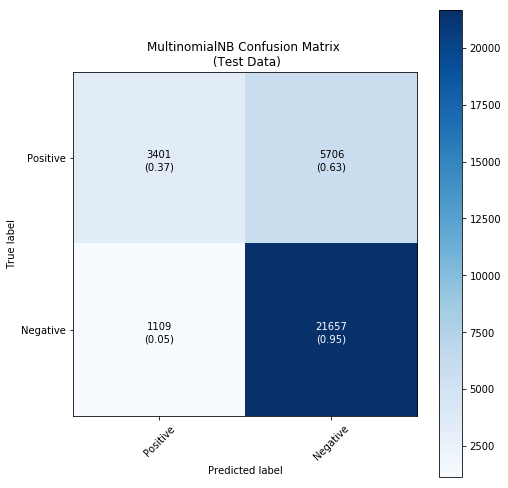

In [8]:
# find and fit best mulitnomial Naive Bayes model (without removing stopwords) and evaluate on test data
min_dfs = range(1,10)
get_best_model(min_dfs, mnb_cv)

### Logistic Regression


We'll repeat the same process above and see how Logistic Regression performs with and without removing stopwords, then we'll tune and cross validate the better performing model (based on f1-score) using GridsearchCV and then we'll evaluate it on the test data.

In [9]:
# make testing and traning data with nltk stopwords removed
x_train, y_train, x_test, y_test = make_xy(df_tweets_train, 
                                           df_tweets_test, 
                                           vectorizer=TfidfVectorizer(ngram_range=(1, 2), 
                                                                      token_pattern=r'\b\w+\b',
                                                                      stop_words=nltk_stopwords))

# create parameter grid of regularization constants to search through
c_space = np.logspace(-4,4,10)
lr_param_grid = {'C': c_space}

# build logistic regression model and cross validate using GridSearchCV
logreg = LogisticRegression(solver='lbfgs', max_iter=5000, random_state=7)
logreg_cv = GridSearchCV(logreg, lr_param_grid, scoring='f1', cv=10, n_jobs=-1)

start = time.time()
print()
print("Cross validating model (with stopwords removed)...")
print()
logreg_cv.fit(x_train, y_train)

print("10 fold CV results")
print("------------------")
print("Logistic Regression took {} to fit.".format(return_time(time.time() - start)))
print("Mean CV f1-score: {:.3f}".format(np.mean(logreg_cv.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(logreg_cv.cv_results_['std_test_score'])))

# repeat without removing stopwords
x_train, y_train, x_test, y_test = make_xy(df_tweets_train, df_tweets_test)

start = time.time()
print()
print("Cross validating model (without removing stopwords)...")
print()
logreg_cv.fit(x_train, y_train)

print("10 fold CV results")
print("---------------------------------------------------------------------")
print("Logistic Regression took {} to fit.".format(return_time(time.time() - start)))
print("Mean CV f1-score: {:.3f}".format(np.mean(logreg_cv.cv_results_['mean_test_score'])))
print("Standard deviation: {:.3f}".format(np.mean(logreg_cv.cv_results_['std_test_score'])))


Cross validating model (with stopwords removed)...

10 fold CV results
------------------
Logistic Regression took 1 hours 19 minutes 13 seconds to fit.
Mean CV f1-score: 0.845
Standard deviation: 0.001

Cross validating model (without removing stopwords)...

10 fold CV results
---------------------------------------------------------------------
Logistic Regression took 1 hours 35 seconds to fit.
Mean CV f1-score: 0.849
Standard deviation: 0.001


Finding best min_df...
min_df: 1, Mean CV f1: 0.849
Best min_df: 1, Best mean CV f1: 0.849

Finding best max_df...
max_df: 1.0, Mean CV f1: 0.849
Best max_df: 1.0, Best mean CV f1 0.849

Fitting best model...


LogisticRegression Classification Report (Test Data)
--------------------------------------------------------
              precision    recall  f1-score   support

    Positive       0.73      0.51      0.60      9107
    Negative       0.83      0.93      0.87     22766

   micro avg       0.81      0.81      0.81     31873
   macro avg       0.78      0.72      0.74     31873
weighted avg       0.80      0.81      0.80     31873



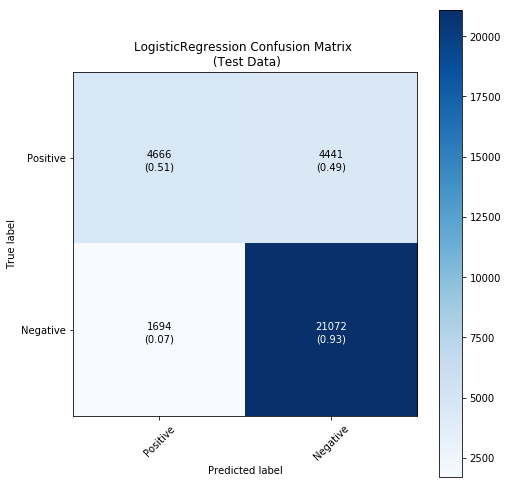

In [10]:
# find and fit best Logistic Regression model (without removing stopwords) and evaluate on test data
get_best_model(min_dfs, logreg_cv)

In [ ]:
# clear memory for Word2Vec model
del mnb, mnb_cv, logreg, logreg_cv

### Word2Vec and CNN+LSTM Network

Now we'll create the Word2Vec vectors from the Spanish vocabulary in our 'word2vec_tweets.txt' data then we'll create the Convoluted Neural Network (CNN) with a Long Short Term Memory (LSTM) network and use the Word2Vec vectors as features to train our CNN+LSTM model.

In [7]:
# create list of Tweets from 'word2vec_tweets.txt' file to create word2vec vectors
tweets_list = []
with open('../data/processed/word2vec_tweets.txt', 'r', buffering=1000) as f:
    for line in f:
        tweets_list.append(line.strip().split())

In [8]:
# set dimension of vectors and 'window' (number of words to consider to the left and right of center word)
VECTOR_SIZE = 300
WINDOW = 2

word2vec_model = 'word2vec.model'

print('Generating Word2Vec Vectors ..')

start = time.time()

# create word2vec model / vectors
model = Word2Vec(sentences=tweets_list, vector_size=VECTOR_SIZE, window=WINDOW, negative=20, workers=4)

print('Word2Vec Created in {}.'.format(return_time(time.time() - start)))

# save model
save_path = os.path.join('../models/', word2vec_model)
model.save(save_path)
print('Word2Vec Model saved at {}'.format(save_path))

Generating Word2Vec Vectors ..
Word2Vec Created in 13 seconds.
Word2Vec Model saved at ../models/word2vec.model


In [8]:
# load model if not already loaded and extract x_vectors to train CNN+LSTM model on
model = Word2Vec.load('../models/word2vec.model')
x_vectors = model.wv

# clear memory for CNN+LSTM Network
del model

Now let's count the number of tokens (words that have a Word2Vec vector associated with it) in all the Tweets and make a histogram of them. This will help use determine a good number of tokens to consider in every Tweet when creating our features for our CNN+LSTM network.

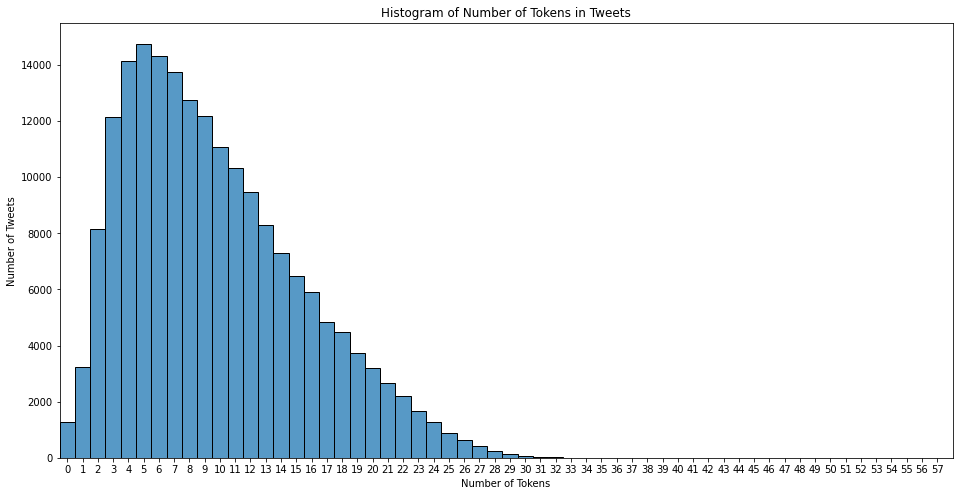

In [11]:
# count number of tokens in tweets
token_counts = [count_tokens(tweet) for tweet in tweets_list]

# plot histogram of number of tokens in Tweets
bins = np.arange(0,max(token_counts)) - 0.5
plt.figure(figsize=(16, 8))
sns.histplot(token_counts, kde=False, bins=bins)
plt.xlim(left=-0.5,right=max(token_counts))
plt.xticks(np.array(range(0,max(token_counts))))
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Tweets')
plt.title('Histogram of Number of Tokens in Tweets')
plt.show()

In [12]:
pct_tweets_lt31_tokens = len([num_tokens for num_tokens in token_counts if num_tokens < 31])/len(token_counts)
print('Fraction of Tweets that contain 30 or less tokens: {:.4f}'.format(pct_tweets_lt31_tokens))

Fraction of Tweets that contain 30 or less tokens: 0.9997


We'll choose 30 to be our max number of token features to create for each Tweet as it covers over 99.9% of tokens in the Tweets and for memory purposes.

Now lets create the training and testing data. y_train and y_test will be the same as used in the previous models, however x_train and x_test are now rank 3 tensors, $T_{x,y,z}$, where x is the number of documents/Tweets, y is the number of tokens/Word2Vec vectors, and z is the dimension of each Word2Vec vector/token.

In [9]:
# create rank 3 tensor from x_train and x_test data from labeled tweets and Word2Vec vectors for CNN+LSTM Network
# y_test and y_train is the same as used in the previous models

# set dimensions of tensor for x_train and x_test
num_of_train_docs = len(df_tweets_train)
num_of_test_docs = len(df_tweets_test)
vector_size = 300
max_no_tokens = 30

# create rank 3 zero tensor for x_train and x_test
x_train = np.zeros((num_of_train_docs, max_no_tokens, vector_size), dtype=K.floatx())
x_test = np.zeros((num_of_test_docs, max_no_tokens, vector_size), dtype=K.floatx())
y_train = (df_tweets_train.sentiment == 'negative').values.astype(np.int)
y_test = (df_tweets_test.sentiment == 'negative').values.astype(np.int)
# create tensors for x_train and x_test

# loop over training Tweets (indices) and x_vectors and place Wvector in tensor where 'token' word is in Tweet
train_indices = df_tweets_train.index
for i, index in enumerate(train_indices):
    for t, token in enumerate(tweets_list[index]):
        if t >= max_no_tokens:
            break
      
        if token not in x_vectors: 
            continue
    
        x_train[i, t, :] = x_vectors[token]

# repeat above with x_test
test_indices = df_tweets_test.index
for i, index in enumerate(test_indices):
    for t, token in enumerate(tweets_list[index]):
        if t >= max_no_tokens:
            break
      
        if token not in x_vectors:
            continue
    
        x_test[i, t, :] = x_vectors[token]

# clear memory
del tweets_list

Now we'll build our CNN+LSTM network, then we'll train and evaluate it.

In [10]:
batch_size = 32
no_epochs = 10

model = Sequential()

model.add(Conv1D(100, kernel_size=3, activation='relu', padding='same',
                 input_shape=(max_no_tokens, vector_size), strides=1))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(100, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(100, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=3))

model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.3)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[km.f1_score()])

tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)

print('Network Architecture')
print('--------------------')
model.summary()

2021-08-09 18:44:51.722381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-09 18:44:51.722411: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-09 18:44:51.722431: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-1-127): /proc/driver/nvidia/version does not exist
2021-08-09 18:44:51.722597: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn
Network Architecture
--------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 100)           90100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 100)           30100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 100)            0         
_________________________________________________________________
co

2021-08-09 18:44:52.208287: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-09 18:44:52.208323: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-09 18:44:52.210422: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [ ]:
start = time.time()

print("CNN-LSTM results")
print("----------------")

# fit model, predict on test data, and print results
model.fit(x_train, y_train, batch_size=batch_size, validation_split=0.2, shuffle=True, epochs=no_epochs, 
          callbacks=[tensorboard, EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)])

print("CNN-LSTM took {} to fit.".format(return_time(time.time() - start)))
print()
Y_pred = model.predict(x_test)
y_pred = np.rint(Y_pred).flatten()

print('Classification Report')
target_names = ['Positive', 'Negative']
print(classification_report(y_test, y_pred, target_names=target_names))

cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
plot_confusion_matrix(cnf_matrix, classes=target_names, title='CNN-LSTM Confusion Matrix \n (Test Data)')

CNN-LSTM results
----------------
Epoch 1/10


2021-08-09 18:45:05.741646: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3671640000 exceeds 10% of free system memory.
2021-08-09 18:45:07.215808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-09 18:45:07.236478: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2800000000 Hz


   5/3188 [..............................] - ETA: 3:49 - loss: 0.6319 - f1_score: 0.8085

2021-08-09 18:45:11.434077: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-09 18:45:11.434126: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-09 18:45:11.464867: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-09 18:45:11.473352: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-08-09 18:45:11.485734: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2021_08_09_18_45_11
2021-08-09 18:45:11.491302: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2021_08_09_18_45_11/ip-172-31-1-127.trace.json.gz
2021-08-09 18:45:11.504913: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/train/plugins/profile/2021_08_09_18_45_11
2021-08-09 18:45:11.504992: 

3187/3188 [============================>.] - ETA: 0s - loss: 0.3290 - f1_score: 0.8803

## Summary of Results and Conclusion

In this project we applied the algorithms Multinomial Naive Bayes, Logistic Regression, and a combination of a Convoluted Neural Network (CNN) with a Long Short Term Memory (LSTM) network to a dataset containing 150K+ Spanish Tweets to classify Tweets as either positive or negative.

The following table summarizes the evaluation metrics used:
    
| Model                   | Mean CV f1-score | Val f1-score | Test f1-score (neg/pos) | Training time |
|-------------------------|------------------|--------------|-------------------------|---------------|
| Multinomial Naive Bayes | .839 (.002)      |  N/A         | .86 / .50               | 0h 0m 12s     |
| Logistic Regression     | .849 (.001)      |  N/A         | .87 / .60               | 1h 0m 35s     |
| CNN + LSTM              | N/A              |  .897        | .89 / .79               | 0h 7m 14s     |

    
Based on the results summarized in the above table, the CNN + LSTM model performed best at classifying both negative and positive Tweets. Although we tuned the models on f1-score for negative Tweets as negative sentiments are often times more useful for improving a product or service, it's important to note the f1-score of positive Tweets as well, as this is an indication of how many correctly classified positive sentiments were made, and therefore the higher this number the less there are of positive Tweets classified as negative. This is where the CNN + LSTM model really shines, as it's f1-score is nearly .20 higher for positive Tweets, meaning that there are a lot less positive Tweets that are incorrectly classified as negative that one would have to sift through manually when determining areas for improvements in a product or service. For further details see the final report in /reports.